In [1]:
%load_ext autoreload

In [2]:
%autoreload 3
from itertools import islice, permutations, product
from importlib import reload
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as display

from tensorflow.contrib.layers import fully_connected, flatten

from magnolia.features.mixer import FeatureMixer
from magnolia.features.wav_iterator import batcher
import magnolia.features.spectral_features as sf
reload(sf)
from magnolia.utils.tf_bits import scope
from magnolia.factorization.pit import PITModel

%matplotlib inline

In [3]:
num_srcs = 2
num_steps = 51
num_freq_bins = 257
batch_size = 512

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def scale_spectrogram(spectrogram):
    mag_spec = np.abs(spectrogram)
    phases = np.unwrap(np.angle(spectrogram))
    
    mag_spec = np.sqrt(mag_spec)
    M = mag_spec.max()
    m = mag_spec.min()
    
    return (mag_spec - m)/(M - m), phases

In [4]:
tf.reset_default_graph()

model = PITModel('pit-s-dnn', num_srcs, num_steps, num_freq_bins, learning_rate=0.0005)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses = []

Tensor("loss/stack:0", shape=(?, 2), dtype=float32)
Tensor("loss/Sum:0", shape=(?,), dtype=float32)
Tensor("loss/stack_1:0", shape=(?, 2), dtype=float32)
Tensor("loss/Sum_1:0", shape=(?,), dtype=float32)
Tensor("loss/stack_2:0", shape=(?, 2), dtype=float32)
Tensor("loss/Min:0", shape=(?,), dtype=float32)
Tensor("loss/Mean_4:0", shape=(), dtype=float32)


In [21]:
librispeech_dev = "/local_data/teams/magnolia/librispeech/processed_dev-clean.h5"
librispeech_train = "/local_data/teams/magnolia/librispeech/processed_train-clean-100.h5"

mixed_features = FeatureMixer([librispeech_dev, librispeech_dev], shape=(num_steps, None))
data_batches = batcher(mixed_features, batch_size)

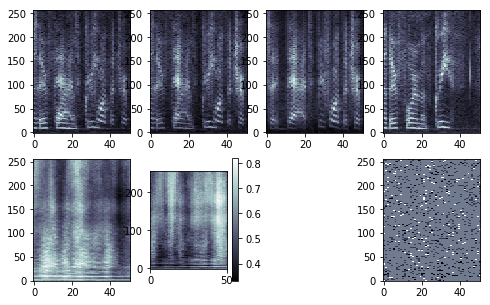

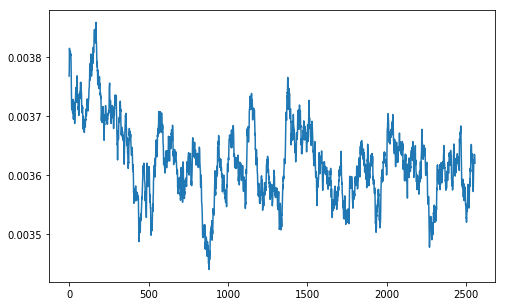

Mix


Recon A


Recon B


Originals


In [ ]:
%pdb off
for i, batch in enumerate(islice(data_batches, 200000)):
    batch_features, batch_ref1, batch_ref2 = batch
    batch_ref1_norm, batch_ref1_norm_phase = scale_spectrogram(batch_ref1) 
    batch_ref2_norm, batch_ref2_norm_phase = scale_spectrogram(batch_ref2)
    batch_features_norm, batch_features_norm_phase = scale_spectrogram(batch_features)
    data = { 
        model.X_in: batch_features_norm,
        model.y_in: np.stack((batch_ref1_norm, batch_ref2_norm), axis=1)
        }
    sess.run(model.optimize, feed_dict=data)
    loss = sess.run(model.loss, feed_dict=data)
    losses.append(loss)
    prediction = sess.run(model.predict, data)
    masks = sess.run(model.mask, data)
    
    if i % 10 == 0:
        orig = sf.reconstruct(batch_features[0], batch_features[0], fs=10000, window_size=None, step_size=0.0256)
        recon_a = sf.reconstruct(prediction[0,0]**2, batch_features[0], fs=10000, window_size=None, step_size=0.0256)
        recon_b = sf.reconstruct(prediction[0,1]**2, batch_features[0], fs=10000, window_size=None, step_size=0.0256)
        orig_a = sf.reconstruct(batch_ref1[0], batch_ref1[0], fs=10000, window_size=None, step_size=0.0256)
        orig_b = sf.reconstruct(batch_ref2[0], batch_ref2[0], fs=10000, window_size=None, step_size=0.0256)
        
        display.clear_output(wait=True)
        plt.figure(figsize=(8,5))
        plt.subplot(2,4,1); plt.imshow(np.sqrt(prediction[0,0].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(2,4,2); plt.imshow(np.sqrt(prediction[0,1].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(2,4,3); plt.imshow(np.sqrt(batch_ref1_norm[0].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(2,4,4); plt.imshow(np.sqrt(batch_ref2_norm[0].T), cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(2,4,5); plt.imshow(masks[0,0].T, cmap='bone', origin='lower', aspect=0.25)
        plt.subplot(2,4,6); plt.imshow(masks[1,0].T, cmap='bone', origin='lower', aspect=0.25)
        plt.colorbar()
        plt.subplot(2,4,8); plt.imshow(np.sum(masks[:,0], axis=0).T, cmap='bone', origin='lower', aspect=0.25)
        
        
        plt.figure(figsize=(8,5))
        plt.plot(moving_average(losses, 50))
        plt.show()
        print("Mix")
        display.display(display.Audio(orig, rate=10000))
        print("Recon A")
        display.display(display.Audio(recon_a, rate=10000))
        print("Recon B")
        display.display(display.Audio(recon_b, rate=10000))
        print("Originals")
        display.display(display.Audio(orig_a, rate=10000))
        display.display(display.Audio(orig_b, rate=10000))

        
    

In [16]:
masks[:,0].sum(axis=0).shape

(51, 257)

In [ ]:
mix, a, b = next(mixed_features)
#mix_fake = np.random.rand(205,257).astype(np.float32)
sources = model.separate(np.abs(mix), sess)
plt.subplot(1,2,1)
plt.imshow(sources[0].T, origin='lower', aspect=1/4,cmap='bone')
plt.subplot(1,2,2)
plt.imshow(sources[1].T, origin='lower', aspect=1/4,cmap='bone')